## **Fig2c,d,e,f** ##

In [1]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

In [2]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [3]:
# model_name = 'processed bonemarrow'
# model_name = 'EG_ab_dyn'
#model_name = 'DentateGyrus'
[k_nei, K, L] = [10, 3, 6]

data_name = 'zebrafish_dynamo_part.h5ad'
result_path = 'Eigen_results/'+data_name+' '+str([k_nei,K,L])+'/'
encoder_path = 'main_results/'+'zebrafish_dynamo_part'+' '+str([k_nei,K,L])+'/'
data_path='data/'
#data_name = 'BoneMarrow/human_cd34_bone_marrow.h5ad'
#data_name = 'processed bonemarrow.h5ad'

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
os.makedirs(result_path, exist_ok=True)

In [4]:
adata0=scv.read(data_path+data_name, cache=True)

In [5]:
adata0

AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:

# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'
cmap = plt.colormaps['Spectral_r']

import scanpy as sc
from scipy.sparse import csr_matrix, identity
adata=adata0.copy()
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
# cell_ppt = adata.obs['palantir_pseudotime'].values
Xs = adata.layers['Ms']#adata.X.A#
# X = Xs
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])

cell_nei=col.reshape([-1,k_nei])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

A = A_mat

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
##Fisher matrix
encoder = torch.load(encoder_path+'encoder.pt')
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
diag_elements = np.concatenate([1 / sigma_learned ** 2, 2 / sigma_learned ** 2], axis=-1)
Fisher_g = np.zeros((X.shape[0], 2 * L, 2 * L))
for i in range(X.shape[0]):
    np.fill_diagonal(Fisher_g[i], diag_elements[i])

In [8]:
#Fisher_g = np.load(result_path+'随机基因2055/'+'k_nei=10/K=3 L=6/'+'Fisher_g.npy')

In [9]:
def EigenIF(Fisher_g):
    n,L,_ = Fisher_g.shape
    L=int(L/2)
    Eigenvalue = np.zeros((n,L))
    for i in range(n):
        for j in range(L):
            Eigenvalue[i,j] = Fisher_g[i,j,j]
    sorted_Eigenvalue = np.sort(Eigenvalue, axis=1)
    sorted_Eigenvalue = sorted_Eigenvalue[:, ::-1]
    relative_Eigenvalue = sorted_Eigenvalue[:,1:]/sorted_Eigenvalue[:,0].reshape(n,1)
    return Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue

Eigenvalue,sorted_Eigenvalue,relative_Eigenvalue = EigenIF(Fisher_g)

In [10]:
# # Compute PAGA
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata)
# sc.tl.leiden(adata)
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=True)
# sc.tl.umap(adata, init_pos='paga')
# sc.pl.umap(adata, color='leiden',edges=True)



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects # === 新增：用于给文字加白边 ===
import os
import scvelo as scv

if "EG" in data_name:
    loc_path_graph = 'upper right'
    axis_name_1 = "Umap1"
    axis_name_2 = "Umap2"
    clusters_name = "clusters"
    clusters_color = "clusters_colors"
elif "zebrafish" in data_name:
    loc_path_graph = 'upper right'
    axis_name_1 = "Umap1"
    axis_name_2 = "Umap2"
    clusters_name = "Cell_type"
    clusters_color = "Cell_type_colors"
elif "DG" in data_name:
    loc_path_graph = 'upper center'
    axis_name_1 = "PCA1"
    axis_name_2 = "PCA2"
    clusters_name = "ClusterName"
    clusters_color = "ClusterName_colors"
    
celltype = adata.obs[clusters_name]

# 获取 scanpy 中细胞类型的颜色映射
if clusters_color in adata.uns:
    cluster_colors = adata.uns[clusters_color]
    cluster_categories = adata.obs[clusters_name].cat.categories
    color_dict = dict(zip(cluster_categories, cluster_colors))
else:
    # 如果没有找到颜色信息，使用默认颜色映射
    unique_types = np.unique(celltype[~pd.isnull(celltype)])
    color_dict = {}
    # 修正：推荐使用新的获取方式，兼容旧版
    try:
        cmap_bg = plt.colormaps['Spectral_r']
    except AttributeError:
        cmap_bg = plt.cm.get_cmap('Spectral_r')
        
    for i, cell_type in enumerate(unique_types):
        color_dict[cell_type] = cmap_bg(i / (max(len(unique_types) - 1, 1)))


idx = ~pd.isnull(celltype)

# 转换为 numpy 数组以进行索引
celltype_vals = np.array(celltype)
celltype_colors = [color_dict[t] for t in celltype_vals[idx]]


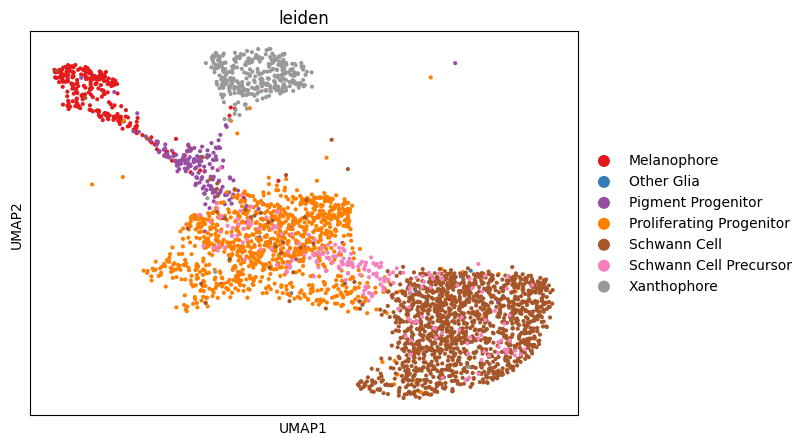

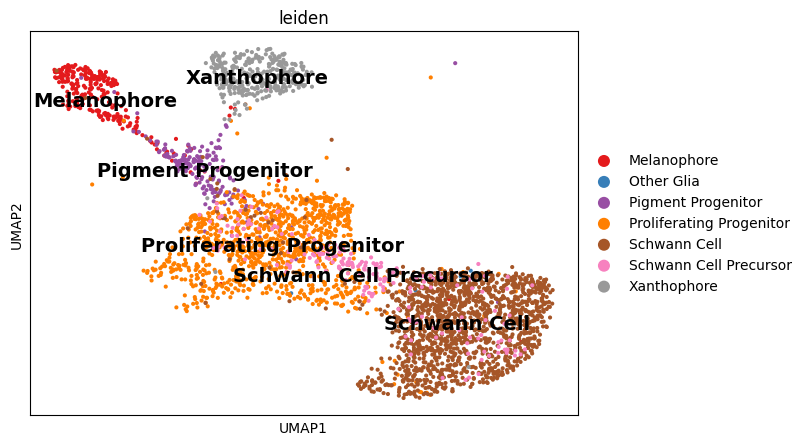

In [12]:
clusters = adata.obs['Cell_type']
adata.obs['leiden'] = clusters
adata0.obs['leiden'] = adata.obs['leiden']
sc.pl.scatter(adata0, basis='umap', color='leiden', palette='Set1', save='zebrafish_clusters_PAGA.png')

ax = sc.pl.scatter(adata0, basis='umap', color='leiden', show=False)

cluster_centers = {}
for cluster in adata0.obs['leiden'].cat.categories:
    # 筛选属于当前聚类的所有细胞
    mask = adata0.obs['leiden'] == cluster
    # 提取这些细胞的UMAP坐标
    umap_coords = adata0.obsm['X_umap'][mask]
    # 计算中心点（使用均值）
    center = np.mean(umap_coords, axis=0)
    cluster_centers[cluster] = center

# --------------- 添加聚类名称标签（跳过 'other glia'）---------------
for cluster, (x, y) in cluster_centers.items():
    if cluster == 'Other Glia':  # 跳过 'other glia' 类别
        continue
    ax.text(
        x, y, str(cluster),        # 坐标和文本
        fontsize=14,               # 字体大小
        weight='bold',             # 加粗
        ha='center', va='center',  # 水平/垂直居中
        color='black',             # 字体颜色
        bbox=dict(                 # 文本框样式
            facecolor='none',      # 背景色
            alpha=0.8,             # 透明度
            edgecolor='none',      # 边框颜色
            boxstyle='round'       # 圆角边框
        )
    )

# plt.savefig('zebrafish_clusters_labeled.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# cluster_color = adata0.uns['leiden_colors']
cluster_color = np.unique(celltype_colors)[np.array([0,5,6,2,1,3])]

In [14]:
clusters = adata.obs['leiden']
# np.save(result_path+'PAGA.npy', np.array(clusters.tolist()))

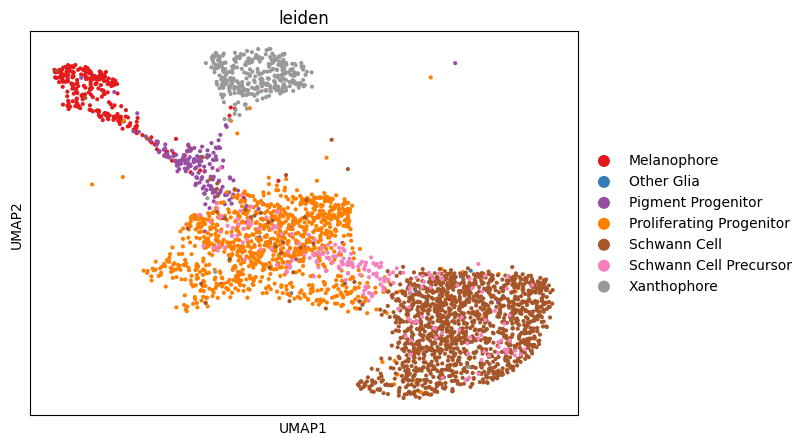

In [15]:
# categories = ['0','2','5','13','3','11','12','8','1','7','10','9','6','4']
# tmp = []
# for i in range(len(clusters)):
#     tmp.append(str(np.where(np.array(categories) == clusters[i])[0][0]))
# adata0.obs['leiden'] = tmp
sc.pl.scatter(adata0, basis = 'umap', color='leiden', save = 'clusters_PAGA.png')

clusters = adata0.obs['leiden']
# np.save(result_path+'PAGA.npy', np.array(clusters.tolist()))

In [16]:
adata.obs['leiden'] = clusters

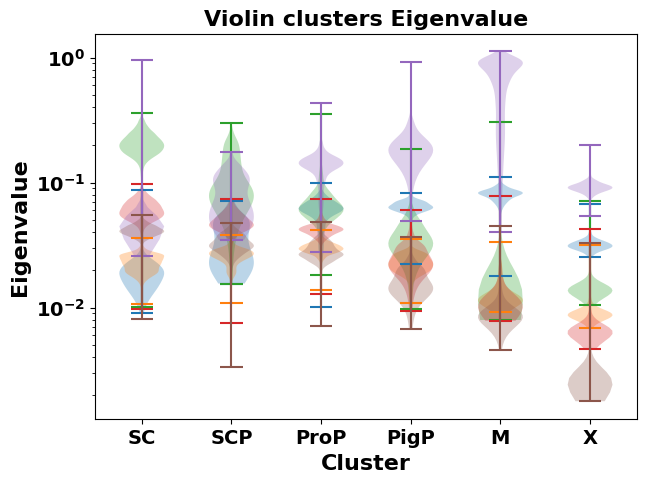

In [17]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)
categories = ['Schwann Cell', 'Schwann Cell Precursor', 'Proliferating Progenitor', 'Pigment Progenitor', 'Melanophore', 'Xanthophore']

categories_simple = ['SC', 'SCP', 'ProP', 'PigP', 'M', 'X']
rot = 0

eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(L):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories_simple,fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.xticks(rotation=rot)

plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=16,weight='bold')
# plt.savefig(result_path+'violin')

plt.show()

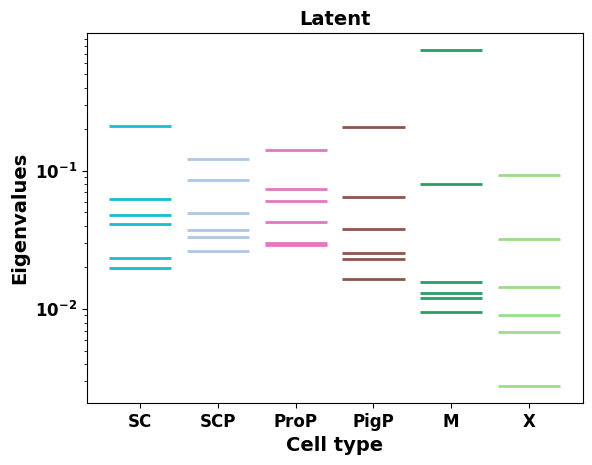

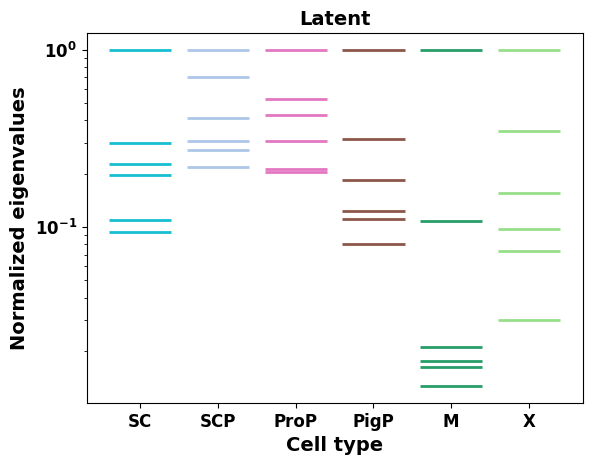

In [18]:
##cluster 均值

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories_simple,fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=rot)
plt.yticks(fontsize=12,fontweight='bold')

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Latent', fontsize=14, fontweight='bold')

# plt.savefig(result_path+'eigen_cluster.png')


plt.show()

##cluster 均值按照第一特征值归一

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)


fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category]
    x = np.full_like(y, i)
    ax.hlines(y/np.max(y), x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories_simple,fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=rot)
plt.yticks(fontsize=12,fontweight='bold')

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Latent', fontsize=14, fontweight='bold')
# plt.savefig(result_path+'eigen_cluster_ratio.png')


plt.show()

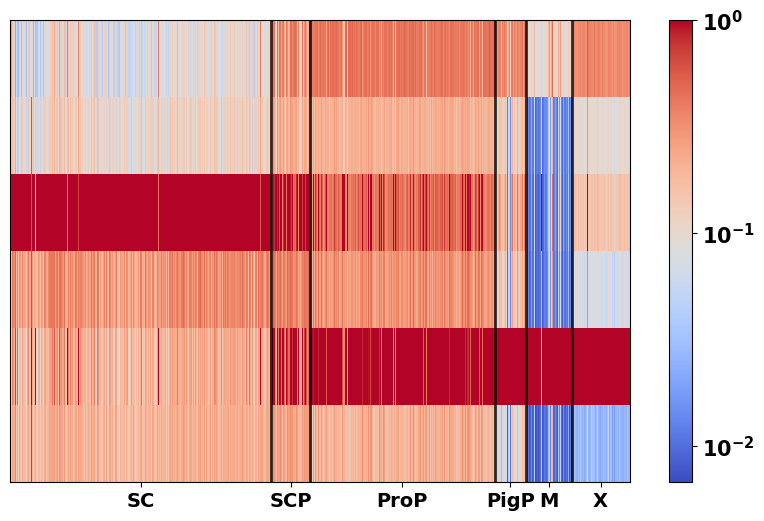

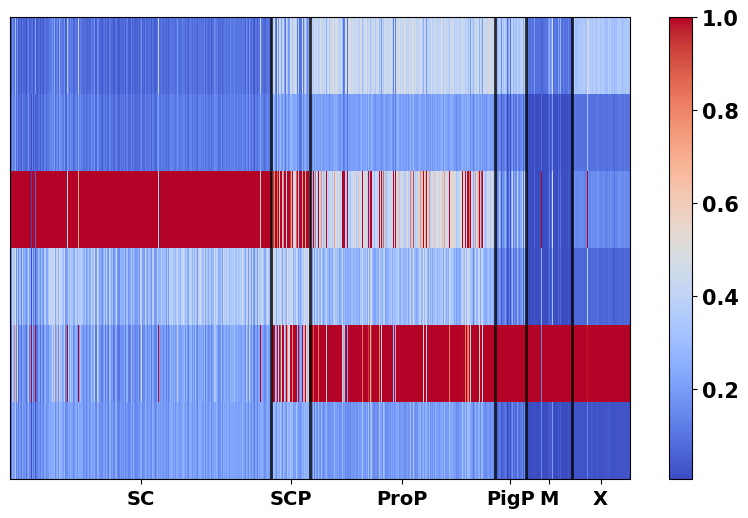

In [19]:
if [k_nei, K, L] == [10, 3, 6]:
    import pandas as pd
    import matplotlib.ticker as ticker


    # 方法1：使用 pandas Categorical 类型（推荐，直接处理分类变量）
    # ---------------------------------------------------------------
    # 将 ClusterName 列转换为分类变量并指定顺序
    adata.obs['ClusterName'] = pd.Categorical(
        adata.obs['Cell_type'], 
        categories=categories,
        ordered=True
    )

    # 获取每个聚类的样本数量（按预设的 categories 顺序）
    categories = adata.obs['ClusterName'].cat.categories
    cluster_counts = adata.obs['ClusterName'].value_counts()[categories]  # 按类别顺序统计

    # 生成排序键（类别对应的整数编码）
    sort_keys = adata.obs['ClusterName'].cat.codes.to_numpy()

    # 获取排序后的索引
    sorted_index = np.argsort(sort_keys)

    # 计算分界线位置（每个聚类结束的索引）
    split_positions = np.cumsum(cluster_counts[:-1])  # 例如：[5, 8] 表示第5和8处画竖线

    # 计算每个聚类标签的 x 轴位置（聚类区域的中心）
    label_positions = np.cumsum(cluster_counts) - cluster_counts / 2  # 例如：[2.5, 6.5, 10]



    # Create the heatmap
    plt.figure(figsize=(10, 6))
    heatmap = plt.imshow(np.log10((Eigenvalue[sorted_index, :]/np.array((np.max(Eigenvalue[sorted_index, :], axis=1),)).T).T), aspect='auto', cmap='coolwarm', interpolation='nearest')

    # 添加竖线分隔聚类
    for pos in split_positions:
        plt.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=2, alpha=0.8)

    # 设置 x 轴标签
    plt.xticks(
        label_positions,          # 标签位置（聚类中心）
        ['SC', 'SCP', 'ProP', 'PigP', 'M', 'X'],     # 标签文本（聚类名称）
        rotation=0,              
        fontsize=14,               # 字体大小
        fontweight = 'bold'
    )
    plt.yticks([])  # 隐藏 y 轴刻度


    # 添加 colorbar
    cbar = plt.colorbar(heatmap)

    # 设置对数刻度格式
    cbar.ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f'$10^{{{x:.0f}}}$')  # 显示为 10^x 格式
    )

    plt.rcParams['text.usetex'] = False  # 若为 True 需系统安装 LaTeX
    plt.rcParams['mathtext.default'] = 'regular'  # 使用常规字体（非斜体）

    # 强制刻度为整数（避免出现 10^0.5）
    cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # 加粗刻度标签（兼容性写法）
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(15)

    plt.draw()

    # # Set x-ticks and y-ticks
    # plt.xticks(ticks=np.arange(30), labels=np.arange(7, 259, 7)[:30])
    # plt.yticks(ticks=np.arange(15), labels=np.arange(0, 30, 2))

    # Show the plot
    # plt.savefig(result_path+'heatmap_log.png')
    plt.show()




    # Create the heatmap
    plt.figure(figsize=(10, 6))
    heatmap = plt.imshow((Eigenvalue[sorted_index, :]/np.array((np.max(Eigenvalue[sorted_index, :], axis=1),)).T).T, aspect='auto', cmap='coolwarm', interpolation='nearest')

    # 添加竖线分隔聚类
    for pos in split_positions:
        plt.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=2, alpha=0.8)

    # 设置 x 轴标签
    plt.xticks(
        label_positions,          # 标签位置（聚类中心）
        ['SC', 'SCP', 'ProP', 'PigP', 'M', 'X'],     # 标签文本（聚类名称）
        rotation=0,              
        fontsize=14,               # 字体大小
        fontweight = 'bold'
    )
    plt.yticks([])  # 隐藏 y 轴刻度

    # ['RG', 'nIPC', 'Nbl1', 'Nbl2', 'IG1', 'IG2', 'G']
    # Add colorbar
    cbar = plt.colorbar(heatmap)
    cbar.ax.tick_params(axis='y', labelsize=15)

    # 加粗colorbar的字体，兼容旧版本 Matplotlib（版本<3.4时labelweight 不可用）
    if not hasattr(cbar.ax, 'labelweight'):
        for label in cbar.ax.get_yticklabels():
            label.set_fontweight('bold')  # 手动加粗


    # # Set x-ticks and y-ticks
    # plt.xticks(ticks=np.arange(30), labels=np.arange(7, 259, 7)[:30])
    # plt.yticks(ticks=np.arange(15), labels=np.arange(0, 30, 2))

    # Show the plot
    # plt.savefig(result_path+'heatmap.png')
    plt.show()

In [20]:
# from sklearn.preprocessing import normalize
# from scipy.cluster.hierarchy import linkage, leaves_list
# Q = np.concatenate([np.array([0]),np.cumsum(cluster_counts.tolist())])
# eig_mat = (Eigenvalue[sorted_index, :]/np.array((np.max(Eigenvalue[sorted_index, :], axis=1),)).T).T

# for i in range(len(Q)-1):
#     data = eig_mat[:, Q[i]:Q[i+1]]
#     # 按某个特征降序排列，获取初始排序索引
#     if i == 2:
#         initial_sort_indices = np.argsort(-data[8, :])  
#         initially_sorted_data = data[:, initial_sort_indices]  
        

#         # normalized_data = normalize(initially_sorted_data.T, norm='l2', axis=1)
#         # inner_product_matrix = np.dot(normalized_data, normalized_data.T)
#         # distance_matrix = 1 - inner_product_matrix

#         # Z = linkage(distance_matrix, method='average')
#         # final_reordered_indices = leaves_list(Z)

#         # final_indices = initial_sort_indices[final_reordered_indices]
#         final_indices = initial_sort_indices
#         eig_mat[:, Q[i]:Q[i+1]] = eig_mat[:, Q[i]:Q[i+1]][:, final_indices]


# # Create the heatmap
# plt.figure(figsize=(10, 6))
# heatmap = plt.imshow(eig_mat, aspect='auto', cmap='coolwarm', interpolation='nearest')

# # 添加竖线分隔聚类
# for pos in split_positions:
#     plt.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=2, alpha=0.8)

# # 设置 x 轴标签
# plt.xticks(
#     label_positions,          # 标签位置（聚类中心）
#     ['SC', 'SCP', 'ProP', 'PigP', 'M', 'X'],     # 标签文本（聚类名称）
#     rotation=0,              
#     fontsize=14,               # 字体大小
#     fontweight = 'bold'
# )
# plt.yticks([])  # 隐藏 y 轴刻度

# # ['RG', 'nIPC', 'Nbl1', 'Nbl2', 'IG1', 'IG2', 'G']
# # Add colorbar
# cbar = plt.colorbar(heatmap)
# cbar.ax.tick_params(axis='y', labelsize=15)

# # 加粗colorbar的字体，兼容旧版本 Matplotlib（版本<3.4时labelweight 不可用）
# if not hasattr(cbar.ax, 'labelweight'):
#     for label in cbar.ax.get_yticklabels():
#         label.set_fontweight('bold')  # 手动加粗

# plt.savefig(result_path+'heatmap_sortcritical.png')
# plt.show()


# # Create the heatmap
# plt.figure(figsize=(10, 6))
# heatmap = plt.imshow(np.log10(eig_mat), aspect='auto', cmap='coolwarm', interpolation='nearest')

# # 添加竖线分隔聚类
# for pos in split_positions:
#     plt.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=2, alpha=0.8)

# # 设置 x 轴标签
# plt.xticks(
#     label_positions,          # 标签位置（聚类中心）
#     ['SC', 'SCP', 'ProP', 'PigP', 'M', 'X'],     # 标签文本（聚类名称）
#     rotation=0,              
#     fontsize=14,               # 字体大小
#     fontweight = 'bold'
# )
# plt.yticks([])  # 隐藏 y 轴刻度


# # 添加 colorbar
# cbar = plt.colorbar(heatmap)

# # 设置对数刻度格式
# cbar.ax.yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, pos: f'$10^{{{x:.0f}}}$')  # 显示为 10^x 格式
# )

# plt.rcParams['text.usetex'] = False  # 若为 True 需系统安装 LaTeX
# plt.rcParams['mathtext.default'] = 'regular'  # 使用常规字体（非斜体）

# # 强制刻度为整数（避免出现 10^0.5）
# cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# # 加粗刻度标签（兼容性写法）
# for label in cbar.ax.get_yticklabels():
#     label.set_fontweight('bold')
#     label.set_fontsize(15)

# plt.draw()

# # # Set x-ticks and y-ticks
# # plt.xticks(ticks=np.arange(30), labels=np.arange(7, 259, 7)[:30])
# # plt.yticks(ticks=np.arange(15), labels=np.arange(0, 30, 2))

# # Show the plot
# plt.savefig(result_path+'heatmap_log_sortcritical.png')
# plt.show()


In [21]:
# from sklearn.preprocessing import normalize
# from scipy.cluster.hierarchy import linkage, leaves_list
# Q = np.concatenate([np.array([0]),np.cumsum(cluster_counts.tolist())])
# eig_mat = (Eigenvalue[sorted_index, :]/np.array((np.max(Eigenvalue[sorted_index, :], axis=1),)).T).T

# for i in range(len(Q)-1):
#     data = eig_mat[:, Q[i]:Q[i+1]]
#     # 按某个特征降序排列，获取初始排序索引
#     initial_sort_indices = np.argsort(-data[8, :])  
#     initially_sorted_data = data[:, initial_sort_indices]  
    

#     # normalized_data = normalize(initially_sorted_data.T, norm='l2', axis=1)
#     # inner_product_matrix = np.dot(normalized_data, normalized_data.T)
#     # distance_matrix = 1 - inner_product_matrix

#     # Z = linkage(distance_matrix, method='average')
#     # final_reordered_indices = leaves_list(Z)

#     # final_indices = initial_sort_indices[final_reordered_indices]
#     final_indices = initial_sort_indices
#     eig_mat[:, Q[i]:Q[i+1]] = eig_mat[:, Q[i]:Q[i+1]][:, final_indices]


# # Create the heatmap
# plt.figure(figsize=(10, 6))
# heatmap = plt.imshow(eig_mat, aspect='auto', cmap='coolwarm', interpolation='nearest')

# # 添加竖线分隔聚类
# for pos in split_positions:
#     plt.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=2, alpha=0.8)

# # 设置 x 轴标签
# plt.xticks(
#     label_positions,          # 标签位置（聚类中心）
#     ['SC', 'SCP', 'ProP', 'PigP', 'M', 'X'],     # 标签文本（聚类名称）
#     rotation=0,              
#     fontsize=14,               # 字体大小
#     fontweight = 'bold'
# )
# plt.yticks([])  # 隐藏 y 轴刻度

# # ['RG', 'nIPC', 'Nbl1', 'Nbl2', 'IG1', 'IG2', 'G']
# # Add colorbar
# cbar = plt.colorbar(heatmap)
# cbar.ax.tick_params(axis='y', labelsize=15)

# # 加粗colorbar的字体，兼容旧版本 Matplotlib（版本<3.4时labelweight 不可用）
# if not hasattr(cbar.ax, 'labelweight'):
#     for label in cbar.ax.get_yticklabels():
#         label.set_fontweight('bold')  # 手动加粗

# plt.savefig(result_path+'heatmap_sortall.png')
# plt.show()


# # Create the heatmap
# plt.figure(figsize=(10, 6))
# heatmap = plt.imshow(np.log10(eig_mat), aspect='auto', cmap='coolwarm', interpolation='nearest')

# # 添加竖线分隔聚类
# for pos in split_positions:
#     plt.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=2, alpha=0.8)

# # 设置 x 轴标签
# plt.xticks(
#     label_positions,          # 标签位置（聚类中心）
#     ['SC', 'SCP', 'ProP', 'PigP', 'M', 'X'],     # 标签文本（聚类名称）
#     rotation=0,              
#     fontsize=14,               # 字体大小
#     fontweight = 'bold'
# )
# plt.yticks([])  # 隐藏 y 轴刻度


# # 添加 colorbar
# cbar = plt.colorbar(heatmap)

# # 设置对数刻度格式
# cbar.ax.yaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, pos: f'$10^{{{x:.0f}}}$')  # 显示为 10^x 格式
# )

# plt.rcParams['text.usetex'] = False  # 若为 True 需系统安装 LaTeX
# plt.rcParams['mathtext.default'] = 'regular'  # 使用常规字体（非斜体）

# # 强制刻度为整数（避免出现 10^0.5）
# cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# # 加粗刻度标签（兼容性写法）
# for label in cbar.ax.get_yticklabels():
#     label.set_fontweight('bold')
#     label.set_fontsize(15)

# plt.draw()

# # # Set x-ticks and y-ticks
# # plt.xticks(ticks=np.arange(30), labels=np.arange(7, 259, 7)[:30])
# # plt.yticks(ticks=np.arange(15), labels=np.arange(0, 30, 2))

# # Show the plot
# plt.savefig(result_path+'heatmap_log_sortall.png')
# plt.show()

In [22]:
#------use a simple neural network to study dmu/dt and dsigma/dt
latent_z = np.hstack((mu_learned,sigma_learned))
pca_dim = adata.obsm['X_pca'].shape[1]

model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(200):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()
        
Fisher_pca = np.zeros((X.shape[0],pca_dim, pca_dim))
for i in range(X.shape[0]):
    Fisher_pca[i] = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]

In [23]:
Fisher_pca_diag = np.zeros_like(Fisher_pca)
for i in range(X.shape[0]):
    Fisher_pca_diag[i] = np.abs(np.diag(np.linalg.eigh(Fisher_pca[i])[0]))
    
Eigenvalue = np.zeros((X.shape[0],pca_dim))
for i in range(X.shape[0]):
    for j in range(pca_dim):
        Eigenvalue[i,j] = Fisher_pca_diag[i,j,j]
Eigenvalue = np.sort(Eigenvalue, axis=1)
Eigenvalue = Eigenvalue[:, ::-1]

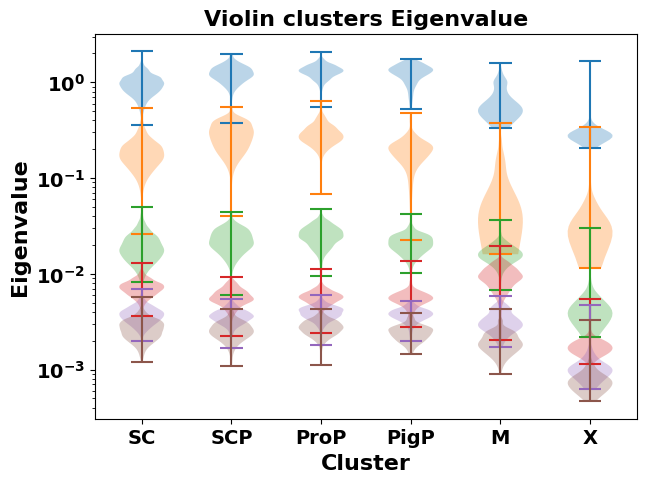

In [24]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)

categories
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(L):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories_simple,fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')

plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=16,weight='bold')
plt.xticks(rotation=rot)
# plt.savefig(result_path+'violin_pca')

plt.show()

## **Eigengene** ##

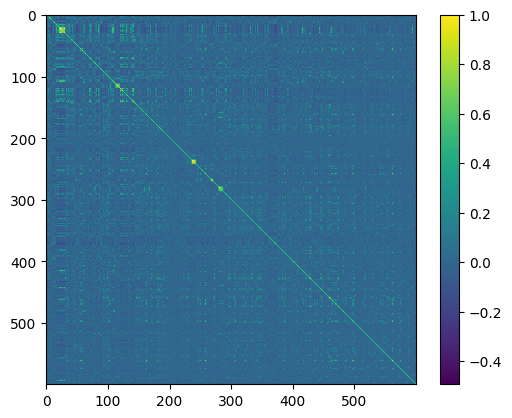

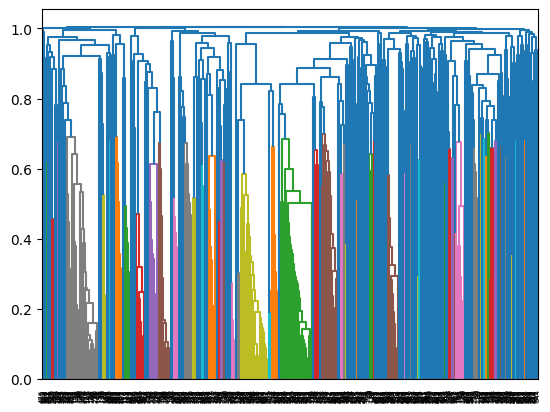

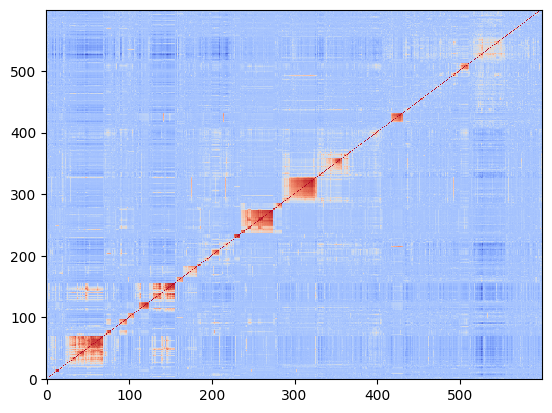

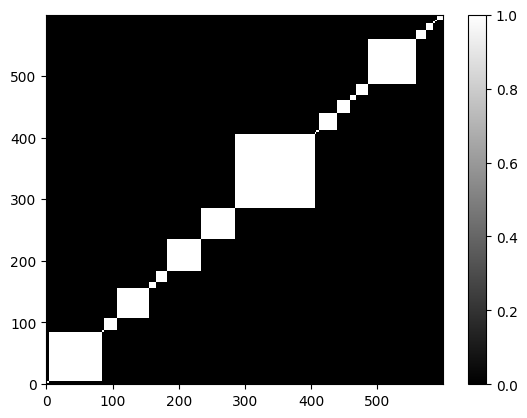

[0.66462487 0.33537522]
[0.42058435 0.31476137]
[0.33716407 0.06532998]
[0.41812614 0.3190138 ]
[0.34477156 0.2687945 ]
[0.3722376  0.18652241]
[0.54420453 0.10436326]
[0.42547202 0.06731554]
[0.14889711 0.12506756]
[0.49114263 0.12619853]
[0.22657494 0.11680169]
[0.57209605 0.42790398]
[0.30220804 0.25881723]
[0.3953483  0.09496942]
[0.1308313  0.09944473]
[0.19097754 0.1531446 ]
[0.1166646  0.08908065]
[0.16306429 0.10435238]
[0.16844115 0.13155122]
[0.14842589 0.12179779]
[0.37331817 0.32279852]
[0.41844547 0.3363116 ]
[0.20548595 0.14603375]
23
(3386, 12, 23)
tensor(0.7894, grad_fn=<MseLossBackward0>)


In [25]:
Xs = adata.layers['Ms']#adata.X.A#
Xu = adata.layers['Mu']
scaler = StandardScaler()#MinMaxScaler()#
X = scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)
plt.show()
td = 0.98
T = fcluster(Z, t=td, criterion='distance')
# T=fcluster(Z, t=td, criterion='maxclust')
T_re = T[dg['leaves']]

plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.show()

X_corr_label = np.zeros(X_corr_re.shape)
for i in range(X_corr_re.shape[0]):
    label_ind = np.where(T_re==T_re[i])[0]
    X_corr_label[i,label_ind] = 1

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()
# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_.T)
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w
eigen_X,eigen_X_w=eigen_gene(X_re,T_re)
eigen_dim=len(np.unique(T_re))
print(eigen_dim)
n_eigen = 1
cell_eigen_X = eigen_X[0,:,:n_eigen]
for i in range(eigen_dim-1):
    cell_eigen_X = np.hstack((cell_eigen_X,eigen_X[i+1,:,:n_eigen]))

from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_eigen_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.002, weight_decay=0.001)

x_in=torch.tensor(cell_eigen_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
    # print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_pEg = np.zeros([cell_eigen_X.shape[0], L*2, cell_eigen_X.shape[1]])

# Compute the gradients
for i in range(cell_eigen_X.shape[0]):
    x0=torch.tensor(cell_eigen_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pEg[i,j,:] = x0.grad.detach()
print(pZ_pEg.shape)
print(loss_fn(model(x_in),x_out))

Fisher_eigen = np.zeros((X.shape[0],eigen_dim*n_eigen,eigen_dim*n_eigen))
for i in range(X.shape[0]):
    Fisher_eigen[i] = pZ_pEg[i].T @ Fisher_g[i] @ pZ_pEg[i]

In [26]:
Fisher_eigen_diag = np.zeros_like(Fisher_eigen)
for i in range(X.shape[0]):
    Fisher_eigen_diag[i] = np.abs(np.diag(np.linalg.eigh(Fisher_eigen[i])[0]))
    
Eigenvalue = np.zeros((X.shape[0],eigen_dim))
for i in range(X.shape[0]):
    for j in range(eigen_dim):
        Eigenvalue[i,j] = Fisher_eigen_diag[i,j,j]
Eigenvalue = np.sort(Eigenvalue, axis=1)
Eigenvalue = Eigenvalue[:, ::-1]

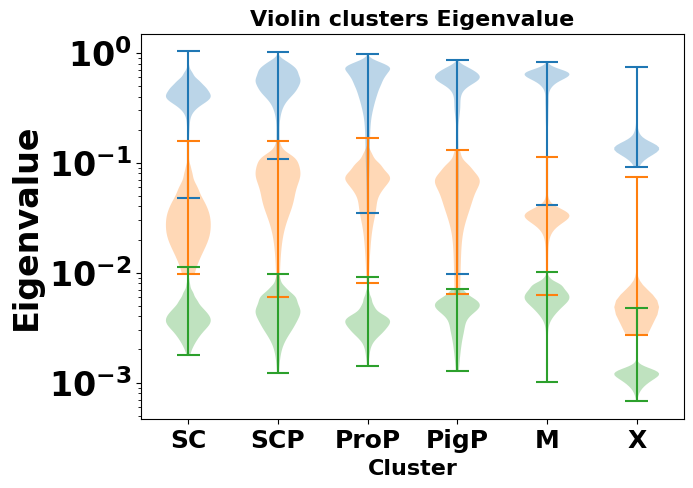

In [27]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)

categories
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(3):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories_simple,fontsize=18,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')


plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=24,weight='bold')
plt.xticks(rotation=rot)
plt.savefig(result_path+'violin_eigen')

plt.show()

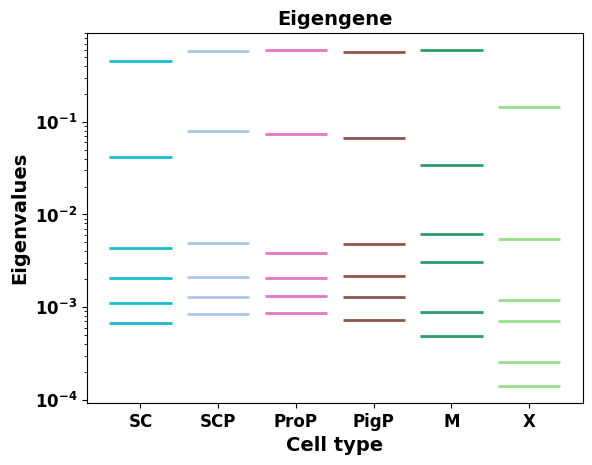

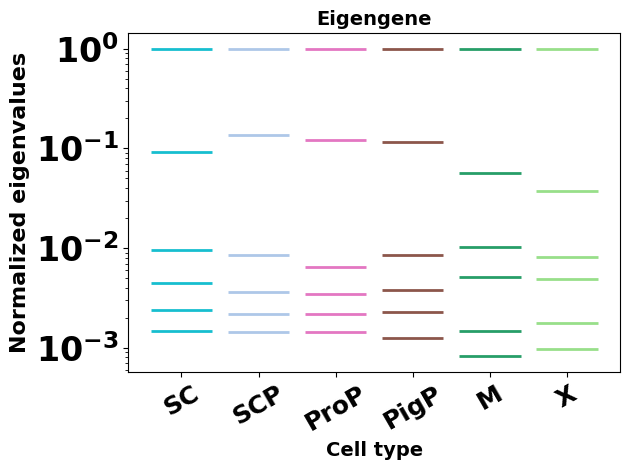

In [28]:
##cluster 均值

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories_simple,fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=rot)
plt.yticks(fontsize=12,fontweight='bold')

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Eigengene', fontsize=14, fontweight='bold')
# plt.savefig(result_path+'eigen_cluster_eigengene.png')


plt.show()

##cluster 均值按照第一特征值归一

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)


fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y[0:L]/np.max(y), x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories_simple,fontsize=18,fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=30)
plt.yticks(fontsize=24,fontweight='bold')

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized eigenvalues', fontsize=16, fontweight='bold')
ax.set_title('Eigengene', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(result_path+'eigen_cluster_ratio_eigengene_recolored.png')

plt.show()

## **Hotspot** ##

In [29]:
import hotspot
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
hs = hotspot.Hotspot(
    adata, 
    model='danb',
    distances_obsp_key = 'distances'
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=k_nei,
)

hs_results = hs.compute_autocorrelations(jobs=1)

# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.1].sort_values('Z', ascending=False).head(800).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)

modules = hs.create_modules(
    min_gene_threshold=10, core_only=True, fdr_threshold=0.1
)

modules.value_counts()
# np.save(result_path+'modules', modules.values)
# np.save(result_path+'hs_genes', hs_genes)


# eigen gene is the value of first principal component of each community
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        if i < 0:
            continue
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

adata_hs = adata[:,hs_genes] # 只用hotspot有效的gene
T_hs = np.array(hs.modules.tolist()) # 记录所有hs gene的module

scaler = StandardScaler()
X_hs = scaler.fit_transform(adata_hs.layers['Ms'])
hs_X, hs_X_w = eigen_gene(X_hs,T_hs)
hs_dim=len(hs_X_w)
print(hs_dim)

cell_hs_X=np.zeros((X_hs.shape[0],hs_dim))
for j in range(X_hs.shape[0]):
    for k in range(len(hs_X_w)):
        cell_hs_X[j,k]=np.dot(hs_X_w[k],X_hs[j,T_hs==k+1])

reset_seeds(0)

model = nn.Sequential(
    nn.Linear(cell_hs_X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(cell_hs_X.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(500):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for each epoch
#         print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Initialize a tensor to store the gradients
pZ_phs = np.zeros([cell_hs_X.shape[0], L*2, cell_hs_X.shape[1]])

# Compute the gradients
for i in range(cell_hs_X.shape[0]):
    x0=torch.tensor(cell_hs_X[i,:].astype(np.float32),requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_phs[i,j,:] = x0.grad.detach()
print(pZ_phs.shape)

Fisher_hs = np.zeros((X.shape[0],hs_dim, hs_dim))
for i in range(X.shape[0]):
    Fisher_hs[i] = pZ_phs[i].T@Fisher_g[i]@pZ_phs[i]

100%|██████████| 600/600 [00:00<00:00, 746.07it/s]


Computing pair-wise local correlation on 302 features...


100%|██████████| 45451/45451 [00:03<00:00, 14994.03it/s]


[0.51506525 0.10410262]
[0.62205374 0.07454817]
[0.23605151 0.0797848 ]
[0.66393054 0.08162098]
[0.1724403  0.08481777]
[0.42787609 0.0900711 ]
[0.2806301  0.14544198]
[0.7325393  0.09394836]
[0.44432712 0.1310581 ]
[0.21024114 0.11194175]
[0.2206244  0.14293918]
11
(3386, 12, 11)


In [30]:
Fisher_hs_diag = np.zeros_like(Fisher_hs)
for i in range(X.shape[0]):
    Fisher_hs_diag[i] = np.abs(np.diag(np.linalg.eigh(Fisher_hs[i])[0]))
    
Eigenvalue = np.zeros((X.shape[0],hs_dim))
for i in range(X.shape[0]):
    for j in range(hs_dim):
        Eigenvalue[i,j] = Fisher_hs_diag[i,j,j]
Eigenvalue = np.sort(Eigenvalue, axis=1)
Eigenvalue = Eigenvalue[:, ::-1]

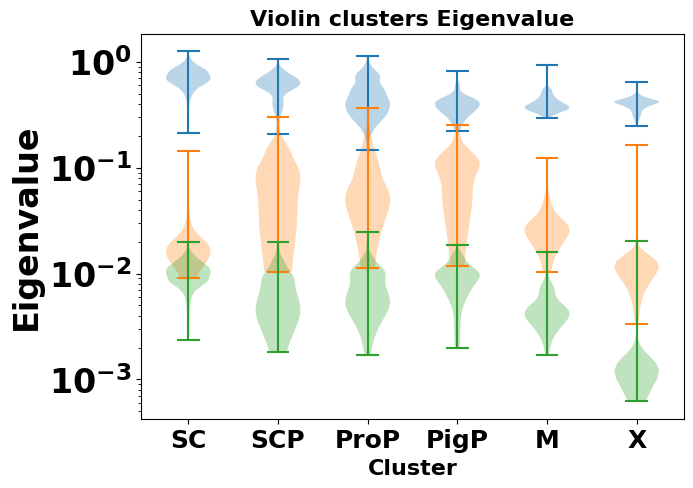

In [31]:
##不同颜色表示不同维度特征值
# categories = list(set(clusters[np.argsort(color_label)]))
# categories.sort(key = list(clusters[np.argsort(color_label)]).index)

categories
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
#plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
for j in range(3):
    plt.violinplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
# 设置x轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories_simple,fontsize=18,fontweight='bold')
plt.yticks(fontsize=24,fontweight='bold')


plt.yscale('log')
# 添加标题和标签
plt.title('Violin clusters Eigenvalue',fontsize=16,weight='bold')
plt.xlabel('Cluster',fontsize=16,weight='bold')
plt.ylabel('Eigenvalue',fontsize=24,weight='bold')
plt.xticks(rotation=rot)
plt.savefig(result_path+'violin_hotspot')

plt.show()

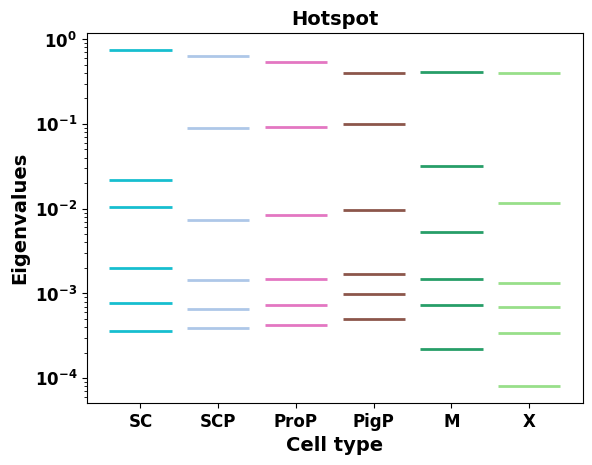

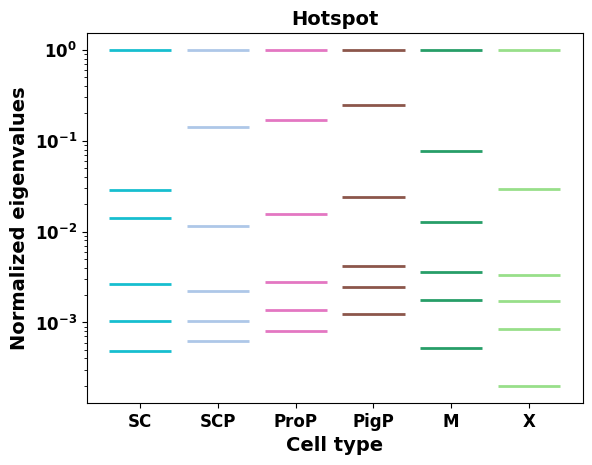

In [32]:
##cluster 均值

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y, x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories_simple,fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=rot)
plt.yticks(fontsize=12,fontweight='bold')

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Hotspot', fontsize=14, fontweight='bold')
# plt.savefig(result_path+'eigen_cluster_hotspot.png')


plt.show()

##cluster 均值按照第一特征值归一

eigenvalues = {}
for i in categories:
    eigenvalues[i] = np.mean(Eigenvalue[clusters==i], axis=0)


fig, ax = plt.subplots()

for i, category in enumerate(categories):
    y = eigenvalues[category][0:L]
    x = np.full_like(y, i)
    ax.hlines(y/np.max(y), x - 0.4, x + 0.4,  lw=2, color = cluster_color[i])

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e1)
#ax.set_yticks([10**i for i in range(-2, 5)])
#ax.set_yticklabels([f'\$10^{{{i}}}$' for i in range(-7, 2)])
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories_simple,fontsize=12, fontweight='bold')

ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=rot)
plt.yticks(fontsize=12,fontweight='bold')

ax.set_xlabel('Cell type', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized eigenvalues', fontsize=14, fontweight='bold')
ax.set_title('Hotspot', fontsize=14, fontweight='bold')
# plt.savefig(result_path+'eigen_cluster_ratio_hotspot.png')


plt.show()

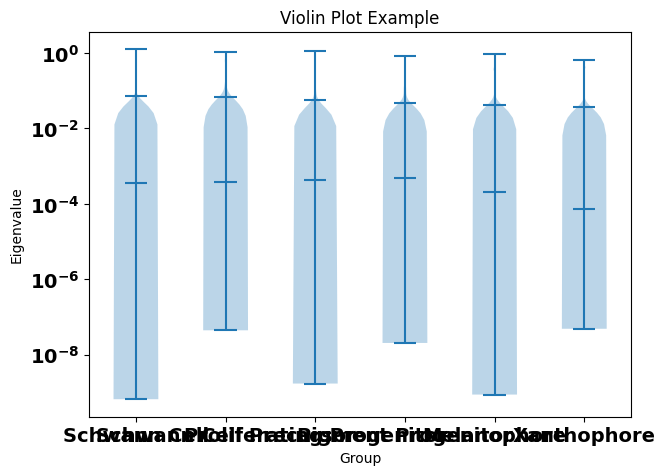

In [33]:
# 合并6个维度violinplot
eigenvalues = {}
for i in categories:
    eigenvalues[i] = Eigenvalue[clusters==i]
plt.figure(figsize=(7, 5))
plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
 
# 设置轴的标签
#plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
plt.xticks(range(1,len(categories)+1),categories,fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')

plt.yscale('log')

# 添加标题和标签
plt.title('Violin Plot Example')
plt.xlabel('Group')
plt.ylabel('Eigenvalue')
 
plt.show()